/usr/bin/python3 -m pip install <package-name>


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("veh.csv")
df.head()

,Distance_km,Duration,HourOfDay,Weekday,Vehicle Speedkm/h,MAFg/sec,Engine RPMRPM,Absolute Load%,OATDegC,Fuel RateL/hr,...,Intersection,Bus Stops,Elevation Rawm,Elevation Smoothedm,fuel_consump,Vehicle Type,Generalized_Weight,Engine_Config,Displacement_L,Engine_Tags
0,-0.469282,-0.589886,0.586518,3,0.444062,0.102233,0.163871,0.676056,-0.196645,0.427055,...,-0.666667,-0.368421,0.157010,0.157010,-0.354001,2,-1.0,3,-0.12,0
1,-0.295355,-0.367064,0.931897,3,0.375156,0.126837,0.125161,0.708331,-0.196645,0.460471,...,-0.666667,-0.368421,0.097402,0.097402,-0.085471,2,-1.0,3,-0.12,0
2,0.183079,0.005507,0.577484,4,0.382005,0.127415,0.007742,0.761134,-0.221226,0.452514,...,-0.333333,0.052632,0.212188,0.212188,0.269308,2,-1.0,3,-0.12,0
3,-0.741790,-0.649404,0.719944,3,0.309051,0.000000,-3.376774,-1.641013,-0.196645,0.000000,...,0.066667,0.000000,0.353244,0.353244,-0.608862,0,0.0,10,-0.72,1
4,-0.393203,0.100821,0.894371,4,0.199297,0.088967,-0.530171,-1.587923,-0.208752,0.644280,...,-0.166667,0.105263,0.260719,0.260719,1.443374,0,0.0,10,-0.72,1


In [3]:
# Define features and target
X = df.drop(columns=['fuel_consump'])  # Drop target
y = df['fuel_consump']                # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)


# Bsic MLP model

In [16]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping

# Define the model building function for the tuner
def build_model(hp):
    model = Sequential()
    
    # Hyperparameters
    units_1 = hp.Int('units_1', min_value=64, max_value=256, step=32)
    units_2 = hp.Int('units_2', min_value=32, max_value=128, step=16)
    units_3 = hp.Int('units_3', min_value=16, max_value=64, step=16)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    l1_reg = hp.Float('l1', min_value=1e-6, max_value=1e-4, sampling='LOG')
    l2_reg = hp.Float('l2', min_value=1e-6, max_value=1e-4, sampling='LOG')

    input_dim = X_train.shape[1]  # Assuming X_train is available
    
    # First hidden layer
    model.add(Dense(units_1, activation='relu', input_shape=(input_dim,),
                    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second hidden layer
    model.add(Dense(units_2, activation='relu',
                    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third hidden layer
    model.add(Dense(units_3, activation='relu',
                    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    # Compile
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    
    return model

# Define tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='mlp_regression_tuning'
)

# Early stopping to avoid overfitting during search
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



Reloading Tuner from my_dir/mlp_regression_tuning/tuner0.json


In [ ]:
# Search for best hyperparameters
tuner.search(X_train, y_train,
             validation_split=0.2,
             epochs=50,
             callbacks=[early_stopping],
             batch_size=32)

In [15]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# (Optional) Print best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

/Users/vluan/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters:
units_1: 256
units_2: 32
units_3: 16
dropout_rate: 0.2
learning_rate: 0.001
l1: 1.3612527425597023e-06
l2: 2.971306121913663e-06
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0065


/Users/vluan/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Add, LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def improved_mlp(input_dim):
    inputs = Input(shape=(input_dim,))
    
    # Block 1
    x = Dense(256, kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    # Block 2
    x_res = x  # Save the residual (shape: 256)

    x = Dense(128, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    # Project residual to match shape
    x_res_proj = Dense(128)(x_res)

    x = Add()([x, x_res_proj])  # Residual connection now valid

    # Block 3
    x = Dense(64, kernel_regularizer=l2(1e-4))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    # Output
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model


In [7]:
model = improved_mlp(X_train.shape[1])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1/150


2025-07-13 21:25:34.600548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1.4010 - mae: 0.7856 - val_loss: 0.3605 - val_mae: 0.3532 - learning_rate: 0.0010
Epoch 2/150
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5544 - mae: 0.4455 - val_loss: 0.2657 - val_mae: 0.2655 - learning_rate: 0.0010
Epoch 3/150
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5022 - mae: 0.4042 - val_loss: 0.2056 - val_mae: 0.2486 - learning_rate: 0.0010
Epoch 4/150
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3569 - mae: 0.3385 - val_loss: 0.1925 - val_mae: 0.2173 - learning_rate: 0.0010
Epoch 5/150
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3957 - mae: 0.3377 - val_loss: 0.1442 - val_mae: 0.1863 - learning_rate: 0.0010
Epoch 6/150
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2934 - mae: 0.3051 - val_loss: 0.1275 - val_mae: 0.1543 - learning_rate: 0.0010
Epoch 7/150
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2696 - mae: 0.2833 - val_loss: 0.1271 - val_mae: 0.1623 - learning_rate: 0.0010
Epoc

In [8]:

# 2. Confirm the shape
print("Test shape for prediction:", X_test.shape)  # Should be (samples, features, 1)

# 3. Predict
y_pred = model.predict(X_test)

# 4. Flatten if needed
y_pred = y_pred.flatten()
print("Predictions shape:", y_pred.shape)  # Should be (samples,)

# 5. Compute Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):      {mae:.4f}")
print(f"R² Score:                        {r2:.4f}")


Test shape for prediction: (13021, 21)
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predictions shape: (13021,)
Root Mean Squared Error (RMSE): 0.2048
Mean Absolute Error (MAE):      0.0585
R² Score:                        0.9704


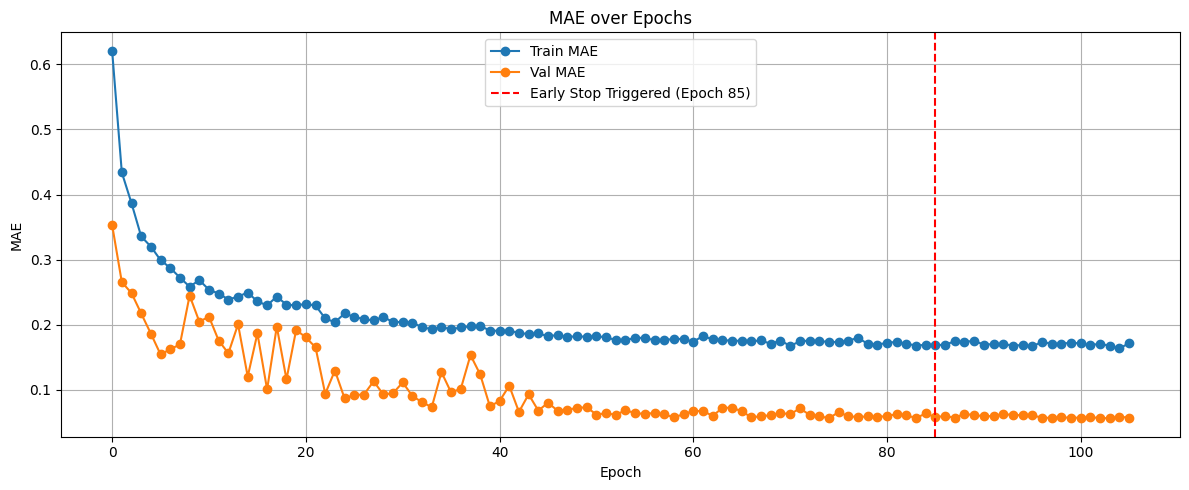

In [18]:
plt.figure(figsize=(12, 5))

# Plot MAE curves
plt.plot(history.history['mae'], label='Train MAE', marker='o')
plt.plot(history.history['val_mae'], label='Val MAE', marker='o')

# Add early stopping line if training was stopped early
if early_stopping.stopped_epoch > 0:
    plt.axvline(
        x=early_stopping.stopped_epoch - early_stopping.patience,
        color='red',
        linestyle='--',
        label=f"Early Stop Triggered (Epoch {early_stopping.stopped_epoch - early_stopping.patience})"
    )

plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
model.save("DNN.keras")  # or .keras in newer formats


In [13]:
from keras.models import load_model

loaded_model = load_model("DNN.keras")


/Users/vluan/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
for layer in loaded_model.layers:
    print(layer.name, layer.get_config())


input_layer_1 {'batch_shape': (None, 21), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer_1'}
dense_2 {'name': 'dense_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': {'module': 'keras.regularizers', 'class_name': 'L2', 'config': {'l2': 0.0001}, 'registered_name': None}, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
batch_normalization_2 {'name': 'batch_normalization_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'axis': -1, 

# Transformer with MLP

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Then reshape again:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


In [6]:
# Tunning model
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
import tensorflow as tf

def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention)

    ff = Dense(ff_dim, activation="relu")(out1)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ff)
    return out2

def build_model(hp):
    head_size = hp.Choice('head_size', values=[32, 64])
    num_heads = hp.Choice('num_heads', values=[2, 4])
    ff_dim = hp.Choice('ff_dim', values=[64, 128, 256])
    dropout = hp.Choice('dropout', values=[0.1, 0.3, 0.5])
    batch_size = hp.Choice('batch_size', values=[32, 64])

    inputs = Input(shape=(X_train_reshaped.shape[1], 1))
    
    x = Dense(128, activation='relu')(inputs)
    x = transformer_block(x, head_size, num_heads, ff_dim, dropout)
    
    x = Dense(64, activation='relu')(x)
    x = transformer_block(x, head_size, num_heads, ff_dim, dropout)
    
    x = Dense(32, activation='relu')(x)
    x = transformer_block(x, head_size, num_heads, ff_dim, dropout)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=['mae']
    )

    return model

In [ ]:
# Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='transformer_tuning',
    project_name='regression'
)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


Reloading Tuner from transformer_tuning/regression/tuner0.json


In [ ]:
# Start tuning
tuner.search(
    X_train_reshaped, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stop]
)

Trial 14 Complete [00h 13m 38s]
val_loss: 0.6648349165916443

Best val_loss So Far: 0.61443030834198
Total elapsed time: 38d 19h 04m 57s

Search: Running Trial #15

Value             |Best Value So Far |Hyperparameter
64                |32                |head_size
2                 |2                 |num_heads
256               |64                |ff_dim
0.5               |0.1               |dropout
32                |32                |batch_size

Epoch 1/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 59s 108ms/step - loss: 0.9751 - mae: 0.6154 - val_loss: 0.7030 - val_mae: 0.5290
Epoch 2/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 54s 111ms/step - loss: 0.8737 - mae: 0.5683 - val_loss: 0.6805 - val_mae: 0.5272
Epoch 3/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 53s 108ms/step - loss: 0.8529 - mae: 0.5678 - val_loss: 0.7245 - val_mae: 0.5467
Epoch 4/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 55s 113ms/step - loss: 0.9124 - mae: 0.5775 - val_loss: 0.7011 - val_mae: 0.5135
Epoch 5/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 55s 112ms/step -

In [25]:
# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate best model
loss, mae = best_model.evaluate(X_test_reshaped, y_test)
print(f"Best model evaluation - Loss: {loss:.4f}, MAE: {mae:.4f}")

/Users/vluan/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


407/407 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.8743 - mae: 0.5201
Best model evaluation - Loss: 0.7394, MAE: 0.5087


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)


{'head_size': 32, 'num_heads': 4, 'ff_dim': 64, 'dropout': 0.5, 'batch_size': 64}


In [21]:
# Best model fit
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping

def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.5):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    ff = Dense(ff_dim, activation="relu")(out1)
    ff = Dropout(dropout)(ff)
    ff = Dense(out1.shape[-1])(ff)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ff)
    return out2

def interleaved_transformer_regression(input_shape):
    head_size = 32
    num_heads = 4
    ff_dim = 64
    dropout = 0.5

    inputs = Input(shape=input_shape)
    
    x = Dense(128, activation="relu")(inputs)
    x = transformer_block(x, head_size, num_heads, ff_dim, dropout)

    x = Dense(64, activation="relu")(x)
    x = transformer_block(x, head_size, num_heads, ff_dim, dropout)

    x = Dense(32, activation="relu")(x)
    x = transformer_block(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    return model

# Instantiate model
model = interleaved_transformer_regression(input_shape=(X_train_reshaped.shape[1], 1))

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

# Fit model with early stopping and batch size = 64
history = model.fit(
    X_train_reshaped,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - loss: 1.1435 - mae: 0.6581 - val_loss: 0.6572 - val_mae: 0.5018
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 0.7982 - mae: 0.5539 - val_loss: 0.6658 - val_mae: 0.5241
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 0.8053 - mae: 0.5385 - val_loss: 0.7453 - val_mae: 0.5210
Epoch 4/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 0.8057 - mae: 0.5504 - val_loss: 0.6760 - val_mae: 0.5212
Epoch 5/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 0.7753 - mae: 0.5588 - val_loss: 0.6448 - val_mae: 0.5075
Epoch 6/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 0.7630 - mae: 0.5408 - val_loss: 0.6959 - val_mae: 0.5590
Epoch 7/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 0.7763 - mae: 0.5549 - val_loss: 0.6509 - val_mae: 0.4930
Epoch 8/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 0.8372 - mae: 0.5580 - val_loss: 0.7466 - val_mae: 0.5586
Epoch 9/100
245/245 ━━━━━━━━━━━━

In [23]:
# Save the model to an HDF5 or TensorFlow SavedModel format (recommended)
model.save("best_transformer_model.keras")  # use .keras or .h5 extension


In [6]:
from tensorflow.keras.models import load_model

# Load the model from file
model = load_model("best_transformer_model.keras")

In [17]:
for layer in reloaded_model.layers:
    print(layer.name, layer.get_config())


input_layer_2 {'batch_shape': (None, 21, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer_2'}
dense_14 {'name': 'dense_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
multi_head_attention_3 {'name': 'multi_head_attention_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'num_heads': 4, 'key_dim': 32, 'value_dim': 32, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'a

In [7]:
# 1. Convert and reshape X_test



# 2. Confirm the shape
print("Test shape for prediction:", X_test_reshaped.shape)  # Should be (samples, features, 1)

# 3. Predict
y_pred = model.predict(X_test_reshaped)

# 4. Flatten if needed
y_pred = y_pred.flatten()
print("Predictions shape:", y_pred.shape)  # Should be (samples,)



Test shape for prediction: (13021, 21, 1)


2025-07-15 14:12:49.688377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


407/407 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Predictions shape: (13021,)


In [8]:
# 5. Compute Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):      {mae:.4f}")
print(f"R² Score:                        {r2:.4f}")


Root Mean Squared Error (RMSE): 0.8520
Mean Absolute Error (MAE):      0.4960
R² Score:                        0.4885


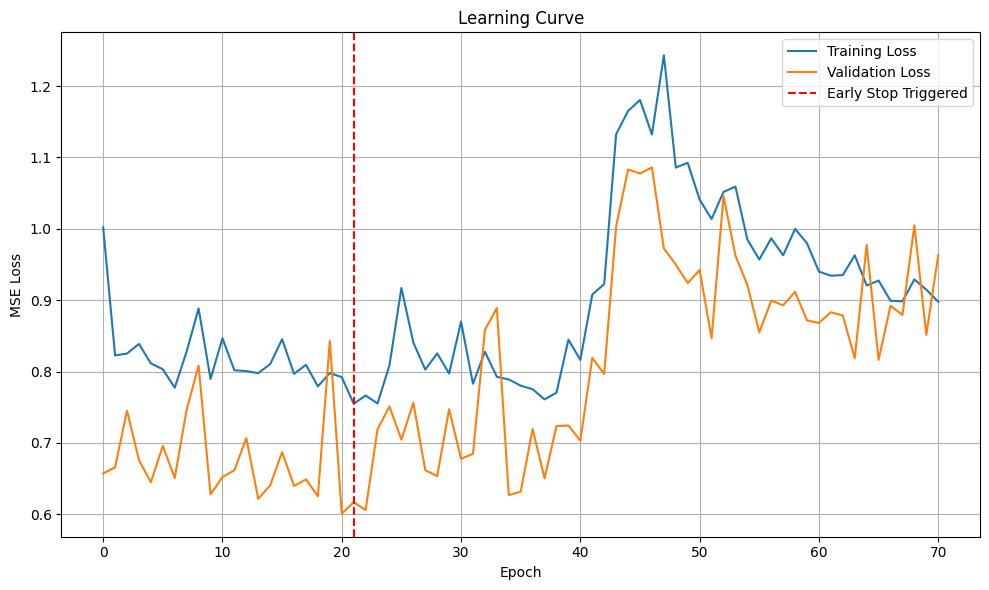

In [24]:
# Plot learning curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.axvline(
    x=len(history.history["val_loss"]) - early_stop.patience,
    color='r',
    linestyle='--',
    label="Early Stop Triggered"
)
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.axvline(
    x=len(history.history["val_mae"]) - early_stop.patience,
    color='r',
    linestyle='--',
    label="Early Stop Triggered"
)
plt.title("Learning Curve (MAE)")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>

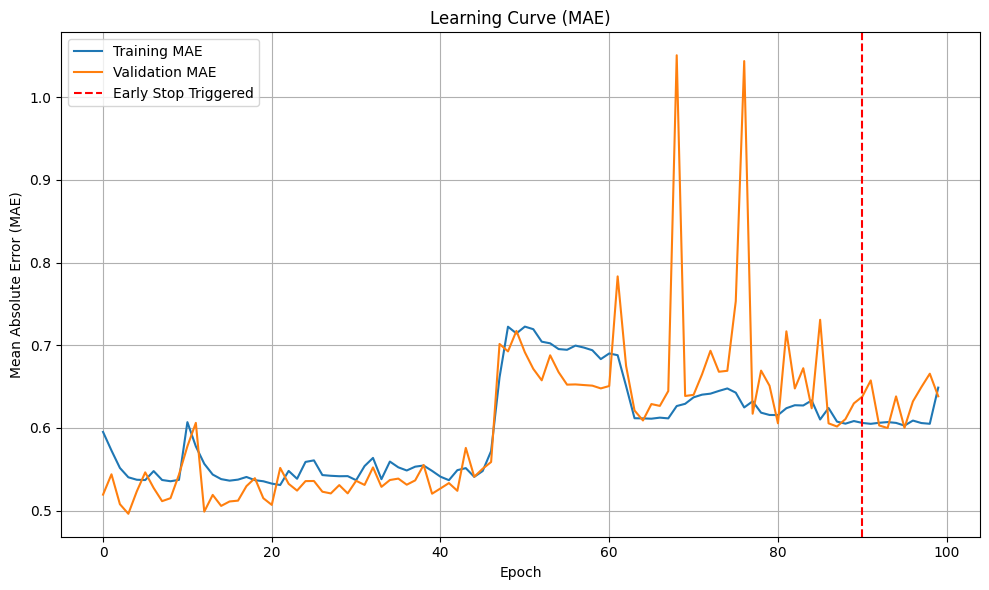

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.axvline(
    x=len(history.history["val_mae"]) - early_stop.patience,
    color='r',
    linestyle='--',
    label="Early Stop Triggered"
)
plt.title("Learning Curve (MAE)")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# TabNet

In [6]:
# Define features and target
X = df.drop(columns=['fuel_consump'])  # Drop target
y = df['fuel_consump']                # Target

# Initial train-test split (80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Further split train_val into train and val (e.g., 75% train, 25% val => 60% train, 20% val total)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)


In [7]:
# Convert targets to numpy (reshaped)
y_train_np = y_train.values.reshape(-1, 1)
y_val_np = y_val.values.reshape(-1, 1)
y_test_np = y_test.values.reshape(-1, 1)

In [12]:
# For tunning code
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define hyperparameter grid
param_grid = {
    'n_d': [8, 16, 32],
    'n_a': [8, 16, 32],
    'n_steps': [3, 5, 7],
    'gamma': [1.0, 1.5],
    'lambda_sparse': [1e-4, 1e-3],
    'batch_size': [512, 1024, 2048],
}


# Track best
best_model = None
best_score = float('inf')
best_params = {}

# Loop over all combinations
from itertools import product
for n_d, n_a, n_steps, gamma, lambda_sparse, batch_size in product(
    param_grid['n_d'],
    param_grid['n_a'],
    param_grid['n_steps'],
    param_grid['gamma'],
    param_grid['lambda_sparse'],
    param_grid['batch_size']
):
    print(f"Training with n_d={n_d}, n_a={n_a}, n_steps={n_steps}, gamma={gamma}, lambda_sparse={lambda_sparse}, batch_size={batch_size}")
    
    # Initialize model
    model = TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_params=dict(lr=2e-2),
        seed=42,
        verbose=0
    )
    
    # Fit model
    model.fit(
        X_train.values, y_train_np,
        eval_set=[(X_val.values, y_val_np)],
        eval_metric=['mae'],
        max_epochs=100,
        patience=10,
        batch_size= batch_size,
        virtual_batch_size= batch_size//8,
        num_workers=0,
        drop_last=False
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test.values).squeeze()
    mae = mean_absolute_error(y_test_np, y_pred)
    
    if mae < best_score:
        best_score = mae
        best_model = model
        best_params = {
            'n_d': n_d,
            'n_a': n_a,
            'n_steps': n_steps,
            'gamma': gamma,
            'lambda_sparse': lambda_sparse,
            'batch_size': batch_size

        }

print("\nBest MAE:", best_score)
print("Best Parameters:", best_params)



Early stopping occurred at epoch 56 with best_epoch = 46 and best_val_0_mae = 0.04893


/Users/vluan/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training with n_d=32, n_a=32, n_steps=7, gamma=1.0, lambda_sparse=0.0001, batch_size=2048

Early stopping occurred at epoch 60 with best_epoch = 50 and best_val_0_mae = 0.04657


/Users/vluan/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training with n_d=32, n_a=32, n_steps=7, gamma=1.0, lambda_sparse=0.001, batch_size=512

Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_mae = 0.0804


/Users/vluan/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training with n_d=32, n_a=32, n_steps=7, gamma=1.0, lambda_sparse=0.001, batch_size=1024

Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_mae = 0.03685


/Users/vluan/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training with n_d=32, n_a=32, n_steps=7, gamma=1.0, lambda_sparse=0.001, batch_size=2048

Early stopping occurred at epoch 90 with best_epoch = 80 and best_val_0_mae = 0.04687


/Users/vluan/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training with n_d=32, n_a=32, n_steps=7, gamma=1.5, lambda_sparse=0.0001, batch_size=512

Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_mae = 0.15544


/Users/vluan/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training with n_d=32, n_a=32, n_steps=7, gamma=1.5, lambda_sparse=0.0001, batch_size=1024

Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_mae = 0.06281


/Users/vluan/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training with n_d=32, n_a=32, n_steps=7, gamma=1.5, lambda_sparse=0.0001, batch_size=2048

Early stopping occurred at epoch 65 with best_epoch = 55 and best_val_0_mae = 0.12415


/Users/vluan/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training with n_d=32, n_a=32, n_steps=7, gamma=1.5, lambda_sparse=0.001, batch_size=512

Early stopping occurred at epoch 99 with best_epoch = 89 and best_val_0_mae = 0.05927


/Users/vluan/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training with n_d=32, n_a=32, n_steps=7, gamma=1.5, lambda_sparse=0.001, batch_size=1024

Early stopping occurred at epoch 79 with best_epoch = 69 and best_val_0_mae = 0.07473


/Users/vluan/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training with n_d=32, n_a=32, n_steps=7, gamma=1.5, lambda_sparse=0.001, batch_size=2048
Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_val_0_mae = 0.10441


/Users/vluan/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Best MAE: 0.01983290273809035
Best Parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 2048}


Result
Best MAE: 0.018564982661834727

Best Parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 2048}

In [13]:
# The best model
# Initialize model
model = TabNetRegressor(
    n_d=8,
    n_a=16,
    n_steps=5,
    gamma=1.0,
    lambda_sparse=0.001,
    optimizer_params=dict(lr=2e-2),
    seed=42,
    verbose=0
)
    
# Fit model
model.fit(
    X_train.values, y_train_np,
    eval_set=[(X_val.values, y_val_np)],
    eval_metric=['mae'],
    max_epochs=100,
    patience=10,
    batch_size= 2048,
    virtual_batch_size= 2048//8,
    num_workers=0,
    drop_last=False
)


Early stopping occurred at epoch 84 with best_epoch = 74 and best_val_0_mae = 0.01869


/Users/vluan/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [14]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions
train_preds = best_model.predict(X_train.values)
test_preds = best_model.predict(X_test.values)

# Metrics
print("Train MSE:", mean_squared_error(y_train_np, train_preds))
print("Test MSE:", mean_squared_error(y_test_np, test_preds))
print("Train R²:", r2_score(y_train_np, train_preds))
print("Test R²:", r2_score(y_test_np, test_preds))


Train MSE: 0.0015099525354727553
Test MSE: 0.00923325894677015
Train R²: 0.9988724308427527
Test R²: 0.9941256339268127


In [16]:
# Predict
y_pred = best_model.predict(X_test.values).flatten()

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
mae = mean_absolute_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

RMSE: 0.0961
MAE:  0.0198
R²:   0.9941


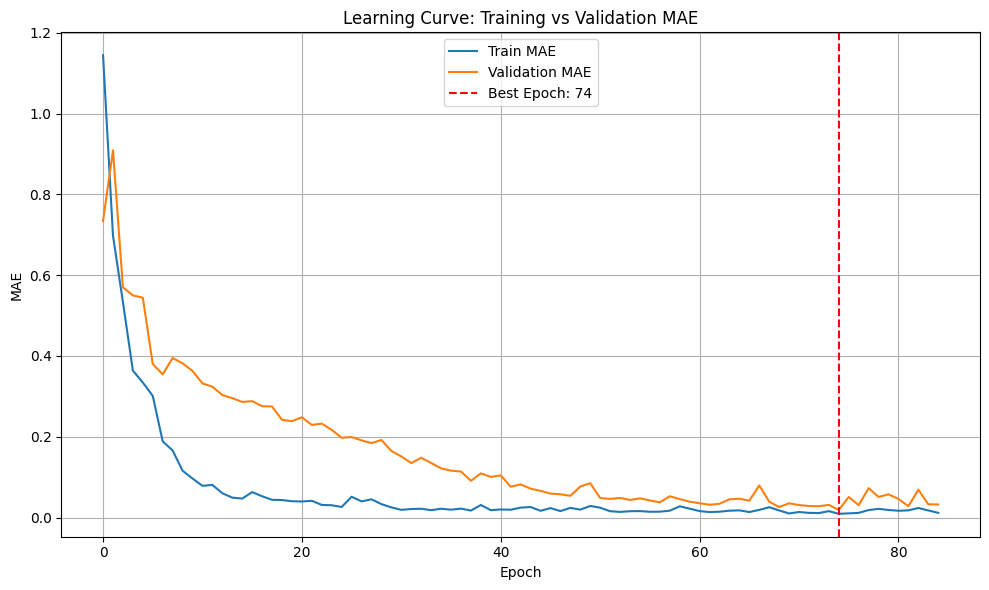

In [17]:
import matplotlib.pyplot as plt

# Extract the metrics using correct keys
train_mae = best_model.history["loss"]
val_mae = best_model.history["val_0_mae"]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Validation MAE')
plt.axvline(x=best_model.best_epoch, color='r', linestyle='--', label=f'Best Epoch: {best_model.best_epoch}')
plt.title("Learning Curve: Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
